# Real-time Steps

In real-time mode, the FPGA lets Xylo run freely and only performs readout after receiving a timestep done interrupt.
This means sending input to Xylo from the FPGA is not supported in real-time mode.  Instead, the switches on the PCB must be configured such that Xylo receives input from the microphones on the PCB.


## Simple Samna example to access the board

In [1]:
ts_duration   = 10*1e-3; # in second
main_clk_freq = 50*1e6 # in Hz
tr_wrap       = int(ts_duration*main_clk_freq)
print(tr_wrap)

# 0: input for Xylo, 1: Xylo output
PDM_CLK_DIR  = 1
# 0: Xylo samples PDM_DATA at risinge edge, 1: Xylo samples PDM_DATA at falling edge
PDM_CLK_EDGE = 0

def get_tr_wrap(ts_in_ms, main_clk_freq_in_mhz, debug=0):
    ts_duration   = ts_in_ms*1e-3; # in second
    main_clk_freq = main_clk_freq_in_mhz*1e6 # in Hz
    tr_wrap       = int(ts_duration*main_clk_freq)
    print(f"set tr_wrap to 0x{format(tr_wrap,'_X')}") if debug>=1 else None
    return tr_wrap

500000


## Example with Rockpool

Open Dev Kit

* Call open_device() on a discovered device with Samna.

In [2]:
import warnings
warnings.filterwarnings("ignore")

import rockpool
print(f'Rockpool version {rockpool.__version__}')
import samna
print(f'Samna version {samna.__version__}')
from rockpool.devices.xylo.syns65302 import config_from_specification, mapper, XyloMonitor, XyloSamna

from rockpool.devices.xylo import find_xylo_hdks

from rockpool.transform.quantize_methods import channel_quantize
from rockpool.nn.modules import LIF, Linear
from rockpool.nn.combinators import Sequential

import numpy as np

# find_xylo_hdks() directly calls the Samna device finder and opens all available devices.
# When Samna opens a device, it will perform actions on the board. Such as, powering on the chip, resetting it,
# applying a default configuration, and configuring the FPGA for default operation.

hdks, modules, versions = find_xylo_hdks()
print(hdks, modules, versions)

for version, xylo in zip(versions, hdks):
    if version == "syns65302":
        xylo_node = xylo

Rockpool version 2.10.0.dev1
Samna version 0.39.9.0
The connected Xylo HDK contains a XyloAudio 3. Importing `rockpool.devices.xylo.syns65302`
[<samna.xyloAudio3.XyloAudio3TestBoard object at 0x74282be8d3f0>] [<module 'rockpool.devices.xylo.syns65302' from '/home/vleite/SynSense/rockpool/rockpool/devices/xylo/syns65302/__init__.py'>] ['syns65302']


## Build a model and map it to hardware

In [3]:
# simple model to test

net = Sequential(
    Linear((16, 63)),
    LIF((63, 63)),

    Linear((63, 16)),
    LIF(16),
)

print(net)

Nin = 16
# net[0].weight *= 0.05
spec = mapper(net.as_graph())
Q_spec = spec
Q_spec.update(channel_quantize(**Q_spec))
config, is_valid, msg = config_from_specification(**Q_spec)

if not is_valid:
    print(msg)

ModSequential  with shape (16, 16) {
    Linear '0_Linear' with shape (16, 63)
    LIF '1_LIF' with shape (63, 63)
    Linear '2_Linear' with shape (63, 16)
    LIF '3_LIF' with shape (16, 16)
}


## Set up Samna graphs and configuration

* Create a buffer sink for events from the chip model source node. Readout events will be captured here.
* Set Xylo configuration as desired for PDM and network config
* Set Xylo TR_WRAP register for desired time step length with default 25 MHz clock
* Set Xylo to real-time mode
* Enable PCB switches for PDM microphones
* Set FPGA module to real-time mode
   * io.write_config(0x12, 0) and io.write_config(0x31, 2)

In [4]:
# create xylo monitor
dt = 0.01
print(xylo_node)


config.operation_mode                                        = samna.xyloAudio3.OperationMode.RealTime
config.time_resolution_wrap                                  = get_tr_wrap(ts_in_ms=1000, main_clk_freq_in_mhz=50, debug=1)
config.debug.always_update_omp_stat                          = True
config.input_source                                          = samna.xyloAudio3.InputSource.DigitalMicrophone
config.digital_frontend.filter_bank.dn_enable                = False
config.digital_frontend.filter_bank.use_global_iaf_threshold = False
config.digital_frontend.pdm_preprocessing.clock_direction    = PDM_CLK_DIR
config.digital_frontend.pdm_preprocessing.clock_edge         = PDM_CLK_EDGE
config.debug.sdm_clock_ratio                                 = 24

# inside XyloMonitor the buffers are created and FPGA modules are set
xylo_monitor = XyloMonitor(device=xylo_node, 
    config=config, 
    dt = dt,
    output_mode='Spike')

# print(xylo_monitor)
xylo_monitor._write_buffer.write([samna.xyloAudio3.event.ReadRegisterValue(0x0004)])
print(xylo_monitor._read_buffer.get_n_events(1, 2000))
# print(xylo_monitor.config)


set tr_wrap to 0x2FA_F080
[xyloAudio3::event::RegisterValue(address=4, data=500000)]


[2024-11-04 03:32:59.134] [XyloAudio3] [warning] Requested SAER clock frequency 12 could not be achieved, used 11.999999040000077 instead
[2024-11-04 03:32:59.134] [XyloAudio3] [warning] Requested SADC clock frequency 12 could not be achieved, used 11.999999040000077 instead


## Start processing and collect events

* Send TriggerProcessing event from Samna with the desired time step
* Collect readout events in the BufferSink attached to the model source node

In [5]:
import numpy as np
T = int(1 / dt) # s / dt

print(T)

out, _, rec = xylo_monitor.evolve(input_data=np.zeros((T, Nin)), record=False, record_power=True)

print(out)


100
[[0 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 1 ... 0 1 0]
 [0 0 1 ... 0 1 0]
 [0 0 1 ... 0 1 0]]


In [6]:
print(rec)


{'io_power': array([0.00189907, 0.00190532, 0.00188027, 0.0019116 , 0.00186782]), 'analog_power': array([3.08593771e-05, 7.32421910e-08, 1.46484382e-07, 2.19726587e-07,
       6.34765638e-06]), 'digital_power': array([0.00140339, 0.0014283 , 0.00142209, 0.0014658 , 0.00149419])}


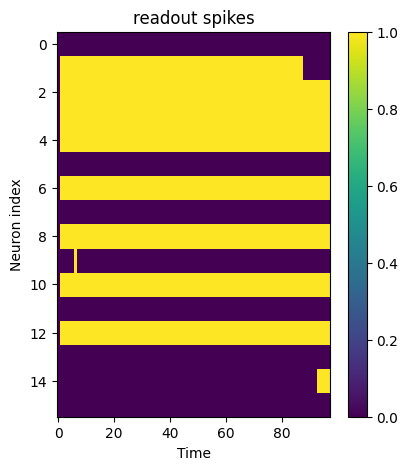

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(np.array(out).T, aspect='auto', interpolation='none'); plt.title('readout spikes'); plt.xlabel('Time'); plt.ylabel('Neuron index'); plt.colorbar()